In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency, f_oneway


In [2]:

# Load dataset
df = pd.read_csv("BankLiquidityRiskDetection.csv")

# Convert dates
df['REPORTINGDATE'] = pd.to_datetime(df['REPORTINGDATE'], dayfirst=True)


In [3]:

# Create financial ratios
df['Liquidity_Ratio'] = df['XX_TOTAL_LIQUID_ASSET'] / df['XX_TOTAL_LIQUID_LIAB']
df['Loan_to_Deposit_Ratio'] = df['EWAQ_GrossLoans'] / df['XX_CUSTOMER_DEPOSITS']
df['Capital_Adequacy_Ratio'] = df['EWAQ_Capital'] / df['F077_ASSETS_TOTAL']


In [4]:

# Handle missing/infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Liquidity_Ratio', 'Loan_to_Deposit_Ratio', 'Capital_Adequacy_Ratio'], inplace=True)


In [5]:

# Create target variable: Liquidity Risk (1 = High Risk, 0 = Low Risk)
df['LiquidityRisk'] = (
    (df['Liquidity_Ratio'] < 1.0) |
    (df['Loan_to_Deposit_Ratio'] > 0.9) |
    (df['Capital_Adequacy_Ratio'] < 0.08)
).astype(int)


In [6]:

# Independent variables and target
X = df[['Liquidity_Ratio', 'Loan_to_Deposit_Ratio', 'Capital_Adequacy_Ratio']]
X_const = sm.add_constant(X)
y = df['LiquidityRisk']

# Logistic Regression Model (Statsmodels)
model = sm.Logit(y, X_const)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.021400
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:          LiquidityRisk   No. Observations:                20874
Model:                          Logit   Df Residuals:                    20870
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Jun 2025   Pseudo R-squ.:                  0.7921
Time:                        14:25:53   Log-Likelihood:                -446.70
converged:                       True   LL-Null:                       -2148.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.1059      0.281      3.941      0.000       0.556     

In [7]:

# Predictions
df['Predicted_Probability'] = result.predict(X_const)
df['Predicted_Class'] = (df['Predicted_Probability'] > 0.5).astype(int)

# Evaluation
print("\nConfusion Matrix:\n", confusion_matrix(y, df['Predicted_Class']))
print("Accuracy:", accuracy_score(y, df['Predicted_Class']))
print("Precision:", precision_score(y, df['Predicted_Class']))
print("Recall:", recall_score(y, df['Predicted_Class']))
print("F1 Score:", f1_score(y, df['Predicted_Class']))
print("\nClassification Report:\n", classification_report(y, df['Predicted_Class']))



Confusion Matrix:
 [[  343   101]
 [   88 20342]]
Accuracy: 0.9909456740442656
Precision: 0.9950594335469354
Recall: 0.9956926089084679
F1 Score: 0.9953759205343381

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78       444
           1       1.00      1.00      1.00     20430

    accuracy                           0.99     20874
   macro avg       0.90      0.88      0.89     20874
weighted avg       0.99      0.99      0.99     20874



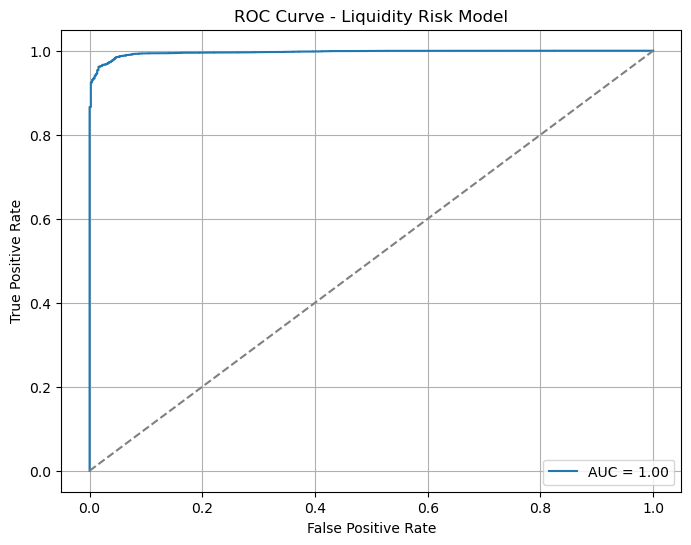

In [8]:

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, df['Predicted_Probability'])
auc = roc_auc_score(y, df['Predicted_Probability'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Liquidity Risk Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [9]:

# Chi-Square Tests
print("\nChi-Square Tests:")
df['Liquidity_Rating_Label'] = df['EWL_LIQUIDITY RATING'].apply(lambda x: 'Strong' if x in ['1', '2'] else 'Not Strong')

for col in ['EWL_LIQUIDITY RATING', 'MLA_CLASS2', 'XX_MLA_CLASS2', 'Liquidity_Rating_Label']:
    table = pd.crosstab(df[col], df['LiquidityRisk'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"{col}: Chi2 = {chi2:.2f}, p = {p:.4f}")



Chi-Square Tests:
EWL_LIQUIDITY RATING: Chi2 = 106.80, p = 0.0000
MLA_CLASS2: Chi2 = 561.10, p = 0.0000
XX_MLA_CLASS2: Chi2 = 587.41, p = 0.0000
Liquidity_Rating_Label: Chi2 = 0.00, p = 1.0000


In [15]:

# ANOVA Tests
print("\nANOVA Tests:")
groups = [group['Liquidity_Ratio'].values for _, group in df.groupby('EWL_LIQUIDITY RATING')]
f_stat, p_val = f_oneway(*groups)
print("Liquidity Ratio by EWL Rating: F =", round(f_stat, 2), "p =", round(p_val, 4))

groups = [group['Capital_Adequacy_Ratio'].values for _, group in df.groupby('EWL_LIQUIDITY RATING')]
f_stat, p_val = f_oneway(*groups)
print("Capital Adequacy Ratio by EWL Rating: F =", round(f_stat, 2), "p =", round(p_val, 4))

groups = [group['Loan_to_Deposit_Ratio'].values for _, group in df.groupby('LiquidityRisk')]
f_stat, p_val = f_oneway(*groups)
print("Loan-to-Deposit Ratio by Liquidity Risk: F =", round(f_stat, 2), "p =", round(p_val, 4))



ANOVA Tests:
Liquidity Ratio by EWL Rating: F = 2.56 p = 0.0254
Capital Adequacy Ratio by EWL Rating: F = 118.15 p = 0.0
Loan-to-Deposit Ratio by Liquidity Risk: F = 2.1 p = 0.1473


In [16]:

# Stress Test: Apply Shocks
df_shock = df.copy()
df_shock['Liquidity_Ratio'] *= 0.75  # 25% decrease
df_shock['Loan_to_Deposit_Ratio'] *= 1.15  # 15% increase
df_shock['Capital_Adequacy_Ratio'] *= 0.9  # 10% decrease

X_shock = df_shock[['Liquidity_Ratio', 'Loan_to_Deposit_Ratio', 'Capital_Adequacy_Ratio']]
X_shock = sm.add_constant(X_shock)
df_shock['Predicted_Probability_Shock'] = result.predict(X_shock)
df_shock['Predicted_Class_Shock'] = (df_shock['Predicted_Probability_Shock'] > 0.5).astype(int)


In [17]:

# Compare risk before vs after shock
before_risky = df['Predicted_Class'].sum()
after_risky = df_shock['Predicted_Class_Shock'].sum()
print("\nStress Test Results:")
print("High-risk institutions before shock:", before_risky)
print("High-risk institutions after shock:", after_risky)



Stress Test Results:
High-risk institutions before shock: 20443
High-risk institutions after shock: 20523


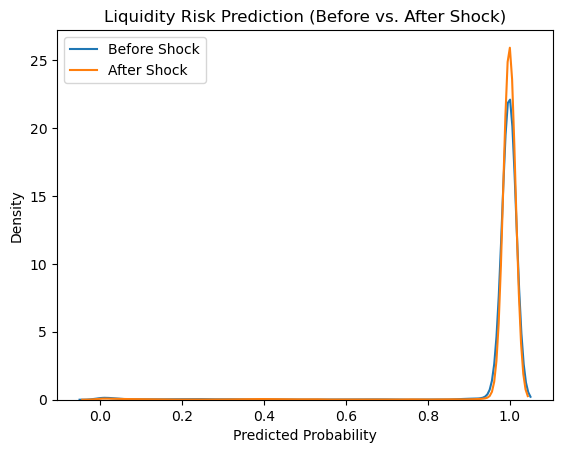

In [18]:

# Probability shift plot
sns.kdeplot(df['Predicted_Probability'], label='Before Shock')
sns.kdeplot(df_shock['Predicted_Probability_Shock'], label='After Shock')
plt.title('Liquidity Risk Prediction (Before vs. After Shock)')
plt.xlabel('Predicted Probability')
plt.legend()
plt.show()


In [19]:

# Per-bank comparison of probability changes
df_comparison = pd.DataFrame({
    'Bank': df['INSTITUTIONCODE'],
    'Prob_Before': df['Predicted_Probability'],
    'Prob_After': df_shock['Predicted_Probability_Shock'],
    'Risk_Before': df['Predicted_Class'],
    'Risk_After': df_shock['Predicted_Class_Shock']
})
df_comparison['Change'] = df_comparison['Prob_After'] - df_comparison['Prob_Before']
df_comparison.sort_values(by='Change', ascending=False, inplace=True)

print("\nTop 25 Banks by Increase in Liquidity Risk Probability After Shock:")
print(df_comparison.head(25))



Top 25 Banks by Increase in Liquidity Risk Probability After Shock:
        Bank  Prob_Before  Prob_After  Risk_Before  Risk_After    Change
14481  B5719     0.148278    0.757235            0           1  0.608957
14485  B5719     0.071096    0.599744            0           1  0.528648
14484  B5719     0.047199    0.531481            0           1  0.484282
14483  B5719     0.048326    0.490148            0           0  0.441822
17346  B5818     0.318774    0.755061            0           1  0.436287
17344  B5818     0.335015    0.766648            0           1  0.431633
14482  B5719     0.044794    0.468380            0           0  0.423586
10075  B5418     0.282997    0.652414            0           1  0.369417
7093   B5219     0.278588    0.644491            0           1  0.365903
7221   B5219     0.395238    0.758467            0           1  0.363229
7220   B5219     0.395238    0.758467            0           1  0.363229
7108   B5219     0.315123    0.673443            0     